In [1]:
# author: Zhuocheng Sun, Yueyu Wang
# instructor: Tyler Caraza-Harter

from shapely.geometry import Point, Polygon
import shapefile as shp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as ctx
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("apartments.csv")
pts_col = []

df = df[df["PropertyClass"] == "Residential"]

for pt in df[["XCoord", "YCoord"]].itertuples():
    pts_col.append(Point(pt.XCoord, pt.YCoord))
df["geometry"] = pts_col
df = df[["Address", "PropertyUse", "Bedrooms", "geometry", "XCoord", "YCoord"]]

df["Bedrooms"] = df["Bedrooms"]  + 0.01 # add a small value to handle 0 bedroom cases.
df = gpd.GeoDataFrame(df)
df = df.set_crs("esri:103412")
df = df.to_crs(epsg=4326)

df = df[["Address", "PropertyUse", "Bedrooms", "geometry", "XCoord", "YCoord"]]

df.head()

/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (42,43,104,109,122) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Address,PropertyUse,Bedrooms,geometry,XCoord,YCoord
0,2333 Carling Dr Unit 4,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813
1,2337 Carling Dr Unit 1,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813
2,2337 Carling Dr Unit 2,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813
3,2337 Carling Dr Unit 3,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813
4,2337 Carling Dr Unit 4,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813


### Generally, 18 year-olds could be either 12th-grade students or college freshmen. Since we found many data entries with majorities of 18-19 year-olds, and many of those properties are located near UW campus, we think it makes more sense to regard them as college students rather than 12th-grade students. Thus, for simplicity, we only count 5 to 17 year-olds as K-12 student in this notebook.

In [3]:
census_df = pd.read_csv("census_by_block_2010/sex_age.csv")
census_df["GEO_ID"] = census_df["GEO_ID"]
census_df = census_df[["GEO_ID", "NAME", "P012001", "P012004", "P012005", "P012006", "P012028", "P012029", "P012030"]]
census_df = census_df.rename(columns = {"NAME":"Area", "P012001": "Total_people", "P012004": "5-9yrMale", "P012005": "10-14yrMale", "P012006": "15-17yrMale", "P012028": "5-9yrFemale", "P012029": "10-14yrFemale", "P012030": "15-17yrFemale"}, inplace=False)
census_df = census_df[1:]
census_df["Total_people"] = census_df["Total_people"].astype(int)
census_df["5-9yr"] = census_df["5-9yrMale"].astype(int) + census_df["5-9yrFemale"].astype(int)
census_df["10-14yr"] = census_df["10-14yrMale"].astype(int) + census_df["10-14yrFemale"].astype(int)
census_df["15-17yr"] = census_df["15-17yrMale"].astype(int) + census_df["15-17yrFemale"].astype(int)

census_df["Total_K-12_block"] = census_df["5-9yr"] + census_df["10-14yr"] + census_df["15-17yr"]
census_df = census_df[census_df["Total_K-12_block"] != 0]
census_df.head()

,GEO_ID,Area,Total_people,5-9yrMale,10-14yrMale,15-17yrMale,5-9yrFemale,10-14yrFemale,15-17yrFemale,5-9yr,10-14yr,15-17yr,Total_K-12_block
1,1000000US550250001001000,"Block 1000, Block Group 1, Census Tract 1, Dan...",170,1,3,1,1,7,4,2,10,5,17
2,1000000US550250001001001,"Block 1001, Block Group 1, Census Tract 1, Dan...",23,1,0,2,0,0,1,1,0,3,4
4,1000000US550250001001003,"Block 1003, Block Group 1, Census Tract 1, Dan...",38,1,1,0,0,1,3,1,2,3,6
5,1000000US550250001001004,"Block 1004, Block Group 1, Census Tract 1, Dan...",141,4,7,4,6,4,3,10,11,7,28
7,1000000US550250001001006,"Block 1006, Block Group 1, Census Tract 1, Dan...",38,1,0,3,0,6,0,1,6,3,10


In [4]:
# spatial join - take dataset A + dataset B = dataset AB, based on space/geographic relationship
# two datasets must have a matched CRS: coordinate reference system

dane = gpd.read_file("dane/dane.shp")
dane["GEO_ID"] = "1000000US" + dane["GEOID20"]
dane.head()

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,GEO_ID
0,55,025,002900,2006,550250029002006,Block 2006,G5040,None,None,None,S,38858,0,+43.0614916,-089.3182030,"POLYGON ((-89.31992 43.06209, -89.31823 43.062...",1000000US550250029002006
1,55,025,012700,1050,550250127001050,Block 1050,G5040,None,None,None,S,1055458,0,+43.0221242,-089.8262570,"POLYGON ((-89.83427 43.02107, -89.83427 43.021...",1000000US550250127001050
2,55,025,011404,4001,550250114044001,Block 4001,G5040,None,None,None,S,47453,0,+43.1937131,-089.2948433,"POLYGON ((-89.29664 43.19458, -89.29664 43.194...",1000000US550250114044001
3,55,025,000504,3015,550250005043015,Block 3015,G5040,None,None,None,S,8739,0,+43.0307340,-089.5300742,"POLYGON ((-89.53060 43.03119, -89.52971 43.031...",1000000US550250005043015
4,55,025,001200,4020,550250012004020,Block 4020,G5040,None,None,None,S,7686,0,+43.0644947,-089.4064235,"POLYGON ((-89.40721 43.06476, -89.40698 43.064...",1000000US550250012004020


In [5]:
dane.to_crs(df.crs, inplace=True)
block_with_apartment = gpd.sjoin(df, dane, how="left", op="within")
block_with_apartment = block_with_apartment[['Address', 'PropertyUse','Bedrooms','geometry', "XCoord", "YCoord",  'GEO_ID']]
block_with_apartment.head()

,Address,PropertyUse,Bedrooms,geometry,XCoord,YCoord,GEO_ID
0,2333 Carling Dr Unit 4,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,1000000US550250006002003
1,2337 Carling Dr Unit 1,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,1000000US550250006002003
2,2337 Carling Dr Unit 2,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,1000000US550250006002003
3,2337 Carling Dr Unit 3,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,1000000US550250006002003
4,2337 Carling Dr Unit 4,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,1000000US550250006002003


#### We now have census data for each block in Madison. To estimate the number of K-12 students in each property, we think using the formula: K-12_est = (number of bedrooms in a property) * (number of K-12 students in the block)/ (number of bedrooms in the block) is a good approach for now.

In [6]:
merged = pd.merge(block_with_apartment, census_df, on="GEO_ID")
merged = merged[["Area","Address", "PropertyUse", "Bedrooms", "geometry", "XCoord", "YCoord", "Total_people", "Total_K-12_block", "GEO_ID"]]
merged['BlockBedrooms'] = merged.groupby(['GEO_ID']).Bedrooms.transform('sum')
merged

,Area,Address,PropertyUse,Bedrooms,geometry,XCoord,YCoord,Total_people,Total_K-12_block,GEO_ID,BlockBedrooms
0,"Block 2003, Block Group 2, Census Tract 6, Dan...",2333 Carling Dr Unit 4,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,204,79,1000000US550250006002003,141.73
1,"Block 2003, Block Group 2, Census Tract 6, Dan...",2337 Carling Dr Unit 1,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,204,79,1000000US550250006002003,141.73
2,"Block 2003, Block Group 2, Census Tract 6, Dan...",2337 Carling Dr Unit 2,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,204,79,1000000US550250006002003,141.73
3,"Block 2003, Block Group 2, Census Tract 6, Dan...",2337 Carling Dr Unit 3,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,204,79,1000000US550250006002003,141.73
4,"Block 2003, Block Group 2, Census Tract 6, Dan...",2337 Carling Dr Unit 4,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,204,79,1000000US550250006002003,141.73
...,...,...,...,...,...,...,...,...,...,...,...
37637,"Block 1015, Block Group 1, Census Tract 109.03...",9026 Bentley Green,Condominium,3.01,POINT (-89.53991 43.04147),779538.794086,470738.980921,30,7,1000000US550250109031015,213.83
37638,"Block 1015, Block Group 1, Census Tract 109.03...",9024 Bentley Green,Condominium,3.01,POINT (-89.53991 43.04147),779538.794086,470738.980921,30,7,1000000US550250109031015,213.83
37639,"Block 1015, Block Group 1, Census Tract 109.03...",9022 Bentley Green,Condominium,3.01,POINT (-89.53991 43.04147),779538.794086,470738.980921,30,7,1000000US550250109031015,213.83
37640,"Block 1015, Block Group 1, Census Tract 109.03...",9020 Bentley Green,Condominium,3.01,POINT (-89.53991 43.04147),779538.794086,470738.980921,30,7,1000000US550250109031015,213.83


In [7]:
merged["K12_est"] = merged["Total_K-12_block"] * merged["Bedrooms"] / merged["BlockBedrooms"]
K12_df = merged
K12_df

,Area,Address,PropertyUse,Bedrooms,geometry,XCoord,YCoord,Total_people,Total_K-12_block,GEO_ID,BlockBedrooms,K12_est
0,"Block 2003, Block Group 2, Census Tract 6, Dan...",2333 Carling Dr Unit 4,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,204,79,1000000US550250006002003,141.73,1.120370
1,"Block 2003, Block Group 2, Census Tract 6, Dan...",2337 Carling Dr Unit 1,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,204,79,1000000US550250006002003,141.73,1.120370
2,"Block 2003, Block Group 2, Census Tract 6, Dan...",2337 Carling Dr Unit 2,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,204,79,1000000US550250006002003,141.73,1.120370
3,"Block 2003, Block Group 2, Census Tract 6, Dan...",2337 Carling Dr Unit 3,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,204,79,1000000US550250006002003,141.73,1.120370
4,"Block 2003, Block Group 2, Census Tract 6, Dan...",2337 Carling Dr Unit 4,Condominium,2.01,POINT (-89.46093 43.02791),800650.916687,465776.525813,204,79,1000000US550250006002003,141.73,1.120370
...,...,...,...,...,...,...,...,...,...,...,...,...
37637,"Block 1015, Block Group 1, Census Tract 109.03...",9026 Bentley Green,Condominium,3.01,POINT (-89.53991 43.04147),779538.794086,470738.980921,30,7,1000000US550250109031015,213.83,0.098536
37638,"Block 1015, Block Group 1, Census Tract 109.03...",9024 Bentley Green,Condominium,3.01,POINT (-89.53991 43.04147),779538.794086,470738.980921,30,7,1000000US550250109031015,213.83,0.098536
37639,"Block 1015, Block Group 1, Census Tract 109.03...",9022 Bentley Green,Condominium,3.01,POINT (-89.53991 43.04147),779538.794086,470738.980921,30,7,1000000US550250109031015,213.83,0.098536
37640,"Block 1015, Block Group 1, Census Tract 109.03...",9020 Bentley Green,Condominium,3.01,POINT (-89.53991 43.04147),779538.794086,470738.980921,30,7,1000000US550250109031015,213.83,0.098536


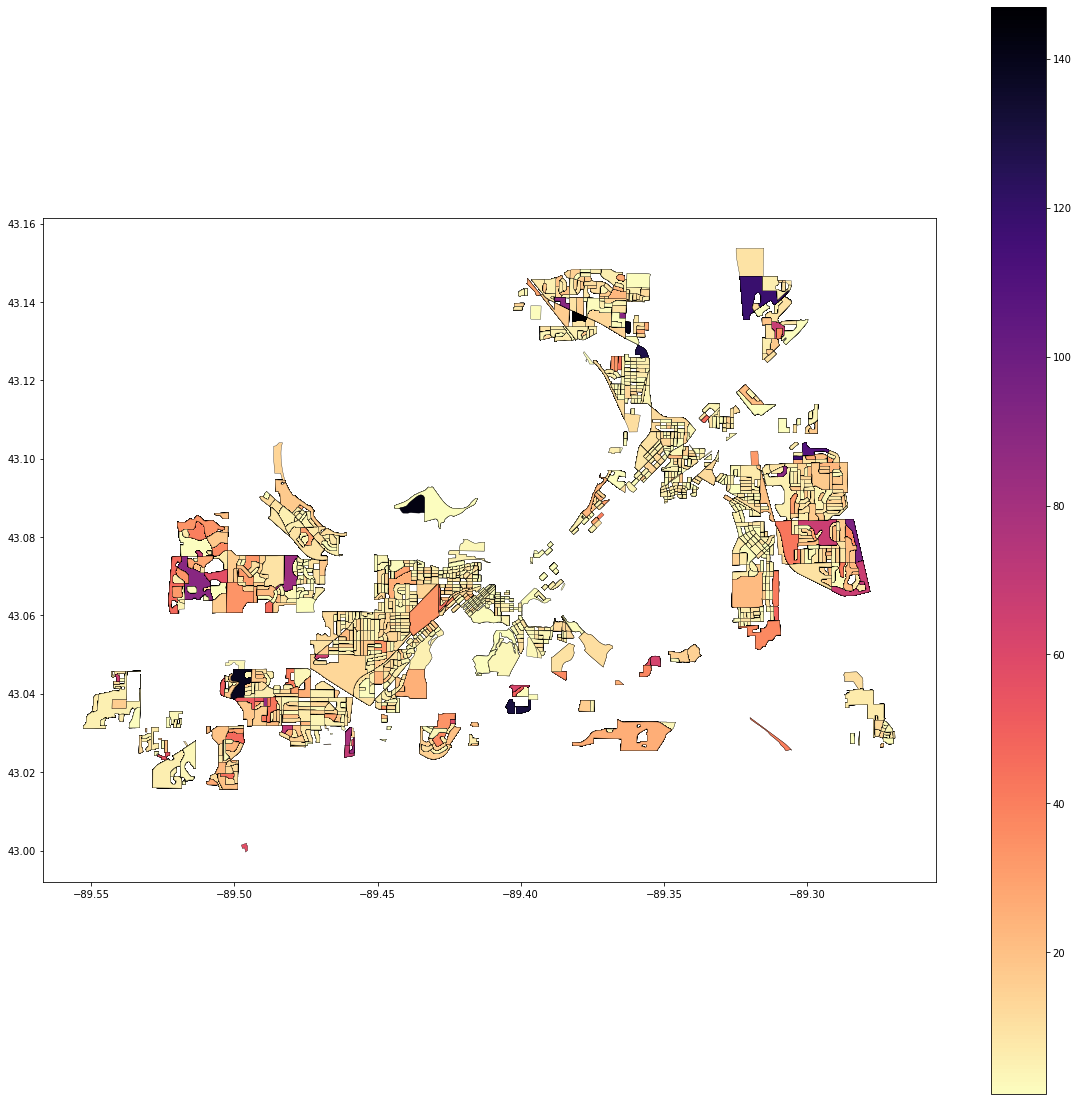

In [8]:
madison = gpd.sjoin(K12_df, dane, how="right", op="within")
madison = madison[madison["Total_K-12_block"] >= 0]
ax = madison.plot(figsize=(20,20), edgecolor='black', linewidth=0.3, column='Total_K-12_block', cmap='magma_r', k=50, legend=True)

In [9]:
# sort by the number of K-12 children estimation grouped by Point.
K12_df["K-12_by_point"] = K12_df.groupby(by=["XCoord", "YCoord"])["K12_est"].transform('sum')
point_order = K12_df.sort_values(by=['K-12_by_point'], ascending=False)

In [10]:
# select out Points with no less than 15 K-12 children.
above_15_point = point_order[point_order['K-12_by_point'] >= 15]
above_15_point[['Address', 'PropertyUse', 'XCoord', 'YCoord', 'K12_est', 'K-12_by_point']].to_csv("Above_15_Point.csv", index=False)
above_15_point.head()


,Area,Address,PropertyUse,Bedrooms,geometry,XCoord,YCoord,Total_people,Total_K-12_block,GEO_ID,BlockBedrooms,K12_est,K-12_by_point
37278,"Block 1001, Block Group 1, Census Tract 32, Da...",2701 Lake Mendota Dr,Vacant,0.01,POINT (-89.43519 43.09015),807538.501985,488460.986586,1353,142,1000000US550250032001001,0.01,142.000000,142.0
37512,"Block 2012, Block Group 2, Census Tract 4.07, ...",957 S Gammon Rd,Vacant,0.01,POINT (-89.50338 43.04400),789303.778668,471649.888130,283,70,1000000US550250004072012,0.01,70.000000,70.0
26973,"Block 2008, Block Group 2, Census Tract 2.05, ...",7408 Old Sauk Rd,Condominium,3.01,POINT (-89.51222 43.07606),786954.418390,483340.753717,299,68,1000000US550250002052008,298.29,0.686178,68.0
26906,"Block 2008, Block Group 2, Census Tract 2.05, ...",7294 Old Sauk Rd,Condominium,2.01,POINT (-89.51222 43.07606),786954.418390,483340.753717,299,68,1000000US550250002052008,298.29,0.458212,68.0
26911,"Block 2008, Block Group 2, Census Tract 2.05, ...",7324 Old Sauk Rd,Condominium,2.01,POINT (-89.51222 43.07606),786954.418390,483340.753717,299,68,1000000US550250002052008,298.29,0.458212,68.0


## Linear Regression part

In [11]:
Condominium_bedroom_block = merged[merged["PropertyUse"] == "Condominium"]
Condominium_bedroom_block = Condominium_bedroom_block[["Area", "Address", "PropertyUse", "Bedrooms", "Total_K-12_block", "GEO_ID", "BlockBedrooms"]]
Condominium_bedroom_block["Apartment_bedroom"] = Condominium_bedroom_block.groupby(['GEO_ID']).Bedrooms.transform('sum')
Condominium_bedroom_block["other_bedroom"] = Condominium_bedroom_block["BlockBedrooms"] - Condominium_bedroom_block["Apartment_bedroom"]
Condominium_bedroom_block = Condominium_bedroom_block.drop_duplicates("GEO_ID")
Condominium_bedroom_block = Condominium_bedroom_block[["GEO_ID", "Apartment_bedroom", "other_bedroom"]]
total_bedroom_block = merged[["GEO_ID", "BlockBedrooms", "Total_K-12_block"]]
total_bedroom_block = total_bedroom_block.drop_duplicates("GEO_ID")
result = total_bedroom_block.merge(Condominium_bedroom_block, on="GEO_ID", how = "outer")
result["Apartment_bedroom"].fillna(0, inplace=True)
result["other_bedroom"].fillna(result["BlockBedrooms"], inplace=True)
result

,GEO_ID,BlockBedrooms,Total_K-12_block,Apartment_bedroom,other_bedroom
0,1000000US550250006002003,141.73,79,141.72,0.01
1,1000000US550250005012004,3.01,2,0.00,3.01
2,1000000US550250006003021,9.04,2,0.00,9.04
3,1000000US550250006002007,27.17,83,0.00,27.17
4,1000000US550250014022008,116.30,37,0.00,116.30
...,...,...,...,...,...
1377,1000000US550250006002001,12.01,14,0.00,12.01
1378,1000000US550250004072012,0.01,70,0.00,0.01
1379,1000000US550250002052009,88.45,7,88.45,0.00
1380,1000000US550250109031015,213.83,7,213.83,0.00


Text(0.5, 1.0, 'Linear Regression Coefficients')

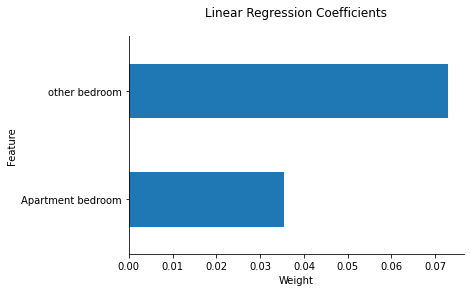

In [12]:
xcol = ["Apartment_bedroom", "other_bedroom"]
model1 = Pipeline([
            ("lr", LinearRegression())
        ])
model1.fit(result[xcol], result["Total_K-12_block"])

idx = [t.replace("_", " ") for t in xcol]
ax3 = pd.Series(model1["lr"].coef_, index=idx).plot.barh()
ax3.set_xlabel("Weight")
ax3.set_ylabel("Feature")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.set_title("Linear Regression Coefficients", pad=20)

## Top 20 apartments table

In [33]:
Top_20 = K12_df
Top_20 = Top_20[Top_20["PropertyUse"] == "Condominium"]
Top_20["Apartment_bedrooms"] = Top_20.groupby(["XCoord", "YCoord"]).Bedrooms.transform(sum)
Top_20 = Top_20.drop_duplicates("geometry")
Top_20 = Top_20.sort_values(by=['K-12_by_point'], ascending=False)
Top_20 = Top_20[:20]
Top_20 = Top_20[["Area", "Address", "geometry", "Apartment_bedrooms", "K-12_by_point"]]
Top_20

/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,Area,Address,geometry,Apartment_bedrooms,K-12_by_point
26865,"Block 2008, Block Group 2, Census Tract 2.05, ...",7318 Old Sauk Rd,POINT (-89.51222 43.07606),298.29,68.000000
0,"Block 2003, Block Group 2, Census Tract 6, Dan...",2333 Carling Dr Unit 4,POINT (-89.46093 43.02791),77.39,43.137021
14067,"Block 2002, Block Group 2, Census Tract 14.01,...",1141 Petra Pl Unit 2,POINT (-89.40292 43.03639),64.33,40.073314
36155,"Block 2010, Block Group 2, Census Tract 26.02,...",4310 Melody Ln Unit 101,POINT (-89.30960 43.13227),465.89,36.000000
40,"Block 2003, Block Group 2, Census Tract 6, Dan...",2354 Allied Dr Unit 2,POINT (-89.46006 43.02748),64.33,35.857405
14040,"Block 2002, Block Group 2, Census Tract 14.01,...",1174 Petra Pl Unit 3,POINT (-89.40245 43.03745),48.25,30.056543
30246,"Block 3004, Block Group 3, Census Tract 24.01,...",1633 Wheeler Rd,POINT (-89.36492 43.14607),335.94,27.000000
37391,"Block 2007, Block Group 2, Census Tract 9.01, ...",1802 Monroe St Unit P625,POINT (-89.41744 43.06516),95.19,24.000000
27683,"Block 2010, Block Group 2, Census Tract 2.02, ...",301 Nautilus Dr Unit CDM,POINT (-89.48887 43.06211),24.09,21.249089
37279,"Block 3000, Block Group 3, Census Tract 5.04, ...",7201 Mid Town Rd Unit 212,POINT (-89.50923 43.03088),124.67,21.000000


## Plots

#### cumulative children live in apartments

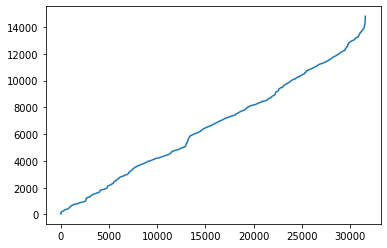

In [19]:
Buildings = K12_df[["GEO_ID", "geometry", "Area", "K-12_by_point"]]
Buildings = Buildings.drop_duplicates("geometry")
K12_data = np.array(Buildings["K-12_by_point"].tolist())
plt.plot(K12_data.cumsum())
plt.axis('tight')
plt.show()

### Simple bar plot: Numbers of bedrooms in apartments, single fam and condos

In [ ]:
# simple bar plot: #bedrooms in apartments, #bedrooms in single fam, #bedrooms in condos
plot1_df = K12_df.groupby(["PropertyUse"]).mean()
plot1_df["Bedrooms"].plot.bar(title="Average number of bedrooms in different properties", rot=60)

### linear regression to predict the number of K-12 child in a bedroom in different properties
#### The plot contains the coefficients for each type of property.
#### The result of this regression is far from what we assumed and the performance of the model is bad.

In [ ]:
diff_use = pd.DataFrame(K12_df.groupby(['GEOID20', 'PropertyUse']).sum()['Bedrooms'])
diff_use = diff_use.reset_index(level=['GEOID20','PropertyUse'])
diff_use = diff_use.pivot(index='GEOID20', columns='PropertyUse', values='Bedrooms')
diff_use = diff_use.fillna(0)

train_df = pd.merge(K12_df[['GEOID20', 'K-12']], diff_use, on='GEOID20')
train_df.drop_duplicates("GEOID20")
model = LinearRegression()
xcols = ["2 Unit", "2 unit Apartment", "3 unit Apartment", "4 unit Apartment", "5 unit Apartment",
         "6 unit Apartment", "7 unit Apartment", "Condominium"]
model.fit(train_df[xcols], train_df["K-12"])
idx = [t.replace("_", " ") for t in xcols]
ax3 = pd.Series(model.coef_, index=idx).plot.barh()
ax3.set_xlabel("Weight")
ax3.set_ylabel("Feature")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.set_title("Figure 3: Logistic Regression Coefficients", pad=20)

### Percentage of bedrooms in Non-apartments of different block size (Number of Bedrooms in a block)

In [ ]:
# x-axis is block size (in bedrooms), y-axis is percent of bedrooms in apartments
total_df = K12_df.groupby(["GEOID20"]).sum()
non_apt_df = K12_df.loc[(K12_df["PropertyUse"] == "Single family") | (K12_df["PropertyUse"] == "2 Unit")
                        | (K12_df["PropertyUse"] == "Condominium")]
non_apt_df = non_apt_df.groupby(["GEOID20"]).sum()
non_apt_p = non_apt_df["Bedrooms"] / total_df["Bedrooms"]
total_df["Non-Apt(%)"] = non_apt_p
ax = total_df.plot.scatter(x="Bedrooms", y="Non-Apt(%)", s=4)
ax.set_xlabel("Block size (Bedrooms)")
ax.set_ylabel("Non-Apartment Property percentage")

### The percentage of K-12 students in different block size

In [ ]:
# x-axis is block size, y-axis is % who K-12
pop_df = K12_df.groupby(["GEOID20", "Total"]).sum()
pop_df.reset_index(level=['Total'], inplace=True)
pop_df = pop_df.groupby(['GEOID20']).sum()
pop_df["K-12(%)"] = 100* pop_df["K-12_est"] / pop_df["Total"]
ax = pop_df.plot.scatter(x="Bedrooms", y="K-12(%)", s=4)
ax.set_xlabel("Block size (Bedrooms)")
ax.set_ylabel("K-12 children percentage")


### The percentage of bedrooms of single largest apartment in different block size

In [ ]:
# x-axis is block size, y-axis is % of bedrooms represented by single largest apartment in that block
Apartment_df = K12_df[K12_df["PropertyUse"] == "Condominium"]
max_apartment = Apartment_df.groupby("GEOID20", as_index=False).apply(lambda t: t[t.Bedrooms==t.Bedrooms.max()])
max_apartment = max_apartment[["Bedrooms", "GEOID20"]]
Total_bedrooms_in_block = K12_df.groupby("GEOID20", as_index=False).sum()
Total_bedrooms_in_block = Total_bedrooms_in_block[["GEOID20", "Bedrooms"]]
tmp = pd.merge(Total_bedrooms_in_block, max_apartment, on="GEOID20")
tmp["percent"] = tmp["Bedrooms_y"] / tmp["Bedrooms_x"] * 100
ax = tmp.plot.scatter(x="Bedrooms_x", y="percent", s=4)
ax.set_xlabel("Block size (Bedrooms)")
ax.set_ylabel("% of bedrooms of single largest apartment in block")

## Buildings(Points) with more than 15 K-12 children (by estimation)
#### Some points in the map may not be exactly one building, but several buildings under the same property group. For example, Wexford Crossing Condominium has many buildings, but they're represented by one Point in the dataset.

In [ ]:
above_15_point = above_15_point.to_crs(epsg=3857)
ax_top = above_15_point['geometry'].drop_duplicates().plot(markersize=5, figsize=(15,15), color="red")
ax_top = ctx.add_basemap(ax_top)

## Top 50 Addresses with most number of K-12 students (by estimatoin)

In [ ]:
unit_order = K12_df.sort_values(by=['K-12_est'], ascending=False)
top50_unit = unit_order.iloc[:50]
top50_unit[['Address', 'PropertyUse', 'XCoord', 'YCoord', 'K-12_est']].to_csv("Top50_units.csv", index=False)

In [ ]:
top50_unit = top50_unit.to_crs(epsg=3857)
ax1 = top50_unit['geometry'].drop_duplicates().plot(markersize=3, figsize=(15,15), color="red")
ax1 = ctx.add_basemap(ax1)

## Properties That May Have K-12 Kids (by estimation)

In [ ]:
K12_df = K12_df.to_crs(epsg=3857)
ax_k12 = K12_df.plot(markersize=0.1, figsize=(20,20), color="red")
ax2 = ctx.add_basemap(ax_k12)

## Makersize Represented by the Number of K-12 Kids (by estimation)

In [ ]:
ax_k12_with_size = K12_df.plot(markersize=K12_df["K-12_by_point"]/10, figsize=(20,20), color="red")
ax3 = ctx.add_basemap(ax_k12_with_size)

## All Residential Properties in City of Madison

In [ ]:
df = df.to_crs(epsg=3857)
ax = df.plot(markersize=0.1, figsize=(20,20))

ctx.add_basemap(ax)